In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
import time
timestr = time.strftime("%d%m%Y")
tag = str("sQNN3-"+timestr)

In [4]:
from qiskit import IBMQ
from qiskit_ibm_provider import IBMProvider 
provider = IBMQ.enable_account(token="be3f937e2d604f9b53d411ad48a467e6d5e9a199249317e1dc2c4eed5659a66ee10655e68b079eda2aeb4b165e59c5c11a9c3a2abb9d31367ae59897b5f54f60")


C:\Users\Samuel\AppData\Local\Temp\ipykernel_1204\240923392.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.enable_account(token="be3f937e2d604f9b53d411ad48a467e6d5e9a199249317e1dc2c4eed5659a66ee10655e68b079eda2aeb4b165e59c5c11a9c3a2abb9d31367ae59897b5f54f60")
C:\Users\Samuel\AppData\Local\Temp\ipykernel_1204\240923392.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_pr

In [5]:
IBMQ.providers()
my_provider = IBMQ.get_provider()
my_provider.backends()
my_provider.get_backend('ibm_nairobi')

<IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
dev = qml.device('qiskit.ibmq', wires=n_qubits, provider=my_provider, backend='ibm_nairobi')
# dev = qml.device("default.qubit", wires=(n_qubits+x_qubits))

Params in the quantum layer to train: 3
0: ──RX(0.39)─╭●──────────╭X──RX(0.26)─╭●───────╭X─╭●─╭●─────────────────────────────────────
1: ──RX(0.22)─╰X─╭●───────│───RX(0.44)─├●─╭●────│──├X─╰RX(0.84)─╭●───────────────────────────
2: ──RX(0.00)────╰X─╭●────│───RX(0.82)─╰X─├●─╭●─│──│────────────╰RX(0.67)─╭●─────────────────
3: ──RX(0.00)───────╰X─╭●─│───RX(0.72)────╰X─├●─├●─│──────────────────────╰RX(0.85)─╭●───────
4: ──RX(0.01)──────────╰X─╰●──RX(0.37)───────╰X─╰●─╰●───────────────────────────────╰RX(0.43)

──╭RX(0.92)─╭●──────────────────────────────────────╭RX(0.46)─┤  <Z>
──│─────────╰RX(0.58)─╭●────────────────────────────│─────────┤  <Z>
──│───────────────────╰RX(0.80)─╭●──────────────────│─────────┤  <Z>
──│─────────────────────────────╰RX(0.90)─╭●────────│─────────┤  <Z>
──╰●──────────────────────────────────────╰RX(0.14)─╰●────────┤  <Z>


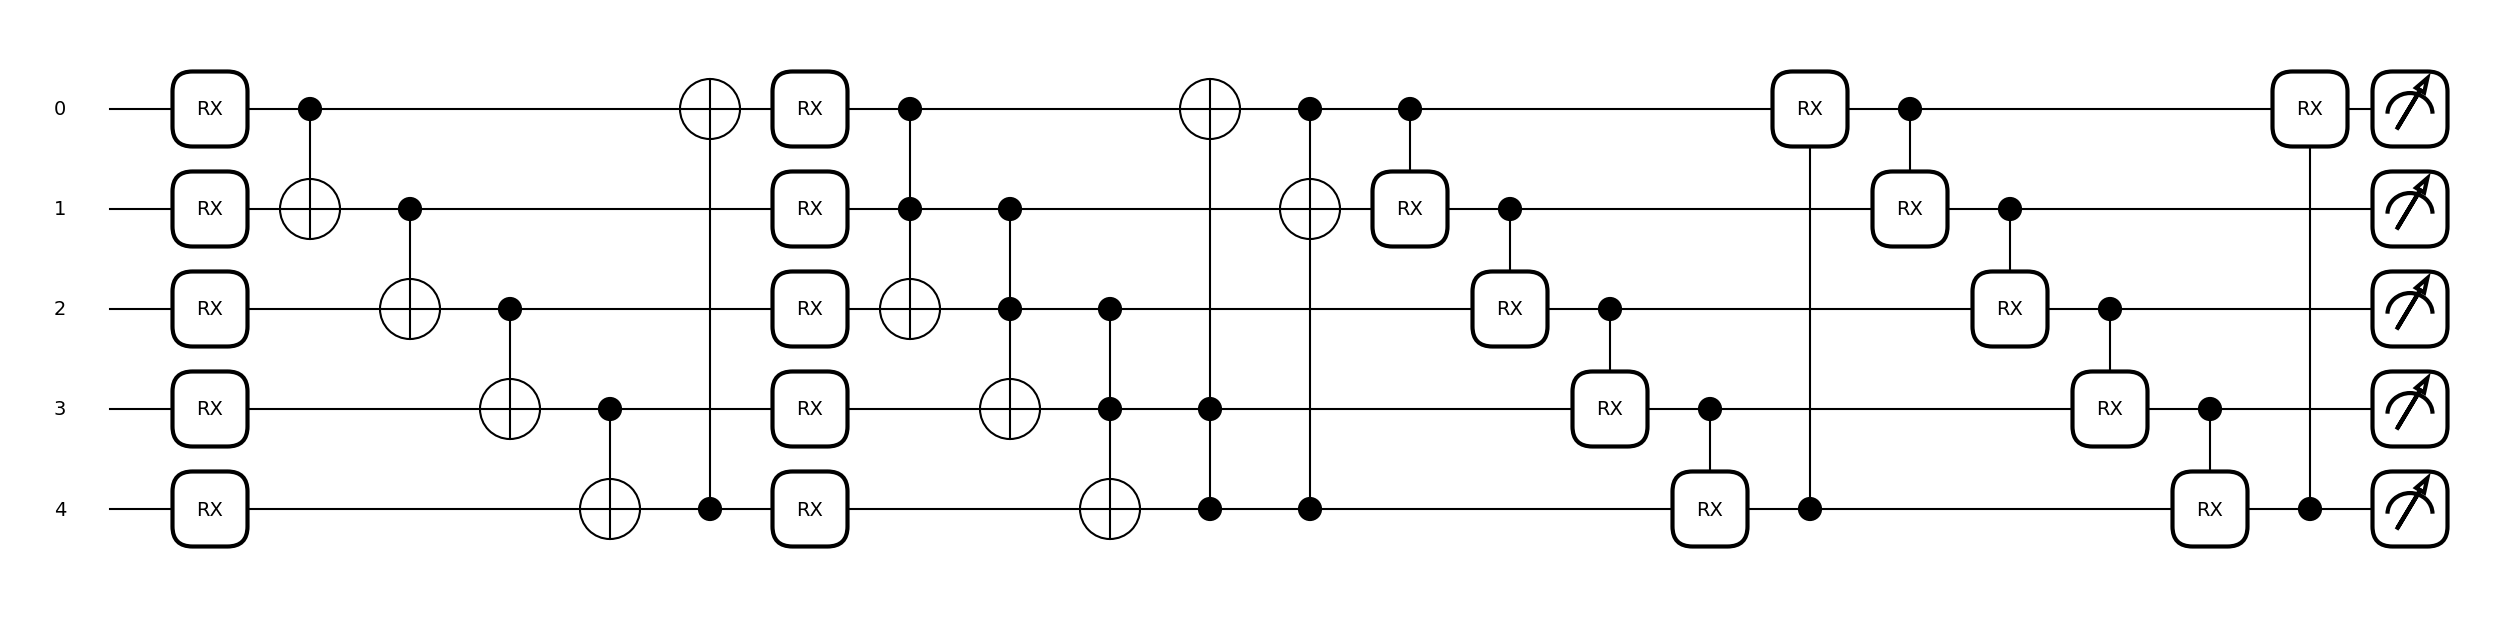

In [10]:
from pennylane import numpy as np
params = 3
weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits),
                 "weight3": (n_qubits)}
n_qcParams = len(weight_shapes)
print(f"Params in the quantum layer to train: {n_qcParams}")

@qml.qnode(dev)
def qnode(inputs, weight1, weight2, weight3):
    # qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.Toffoli(wires=[0,1,2])
    qml.Toffoli(wires=[1,2,3])
    qml.Toffoli(wires=[2,3,4])
    qml.Toffoli(wires=[3,4,0])
    qml.Toffoli(wires=[4,0,1])
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters= weight2, pattern="ring")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters= weight3,  pattern="ring")
    # qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits), np.random.rand(n_qubits)))
fig, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits), np.random.rand(n_qubits))
plt.show()
fig.savefig("archive/Qnode-"+tag+".png")
fig.savefig("archive/Qnode-"+tag+".pdf")

In [11]:
#Create a simple ANN
import numpy as np
clear_session()
tf.keras.backend.set_floatx('float64')
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()
plot_model(ann)

Params in the quantum layer to train: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=5, patience=3)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.2, momentum=0.5)

ann.compile(optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

ann_history = ann.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)

In [ ]:
fig = plt.figure()
plt.plot(ann_history.history['loss'], lw=4, label='loss')
plt.plot(ann_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(ann_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [ ]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])
ann.summary()

In [ ]:
ann.save("archive/model-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)